<a href="https://colab.research.google.com/github/nssn96/ML_Neural-networks/blob/main/ML_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Assignment 3 - Support Vector Machines


1.   Author : Surya Narayanan Nadhamuni Suresh
2.   UTA ID : 1001877873


In [171]:
#References Used for this project
#https://dillhoffaj.utasites.cloud/posts/sequential_minimal_optimization/
#https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/
#https://dillhoffaj.utasites.cloud/posts/support_vector_machine/
#https://github.com/ajdillhoff/CSE6363/blob/main/svm/smo.ipynb
#https://github.com/Reznic/SVM-Project/blob/main/maman13_SVM.ipynb
#https://github.com/ajdillhoff/CSE6363/blob/main/svm/svm_iris_comparison.ipynb

In [172]:
#import lines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions
# %matplotlib widget

In [173]:
#References Used


class for SVM


In [174]:

def linear_kernel(x1, x2):
  # print(x1.shape)
  # print(x2.shape)
  return x1.T @ x2
def poly_kernel(x1,x2,d=3):
  #return ((x1.T @ x2)**d)
  return (1.0 + x1.dot(x2.T)) ** d


class svm_classifier():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=10,d=3):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self.d = d
        
        if self._kernel == 'linear':
          self._k = linear_kernel
        if self._kernel == 'poly':
          self._k = poly_kernel
        elif self._kernel==np.dot:
          self._k=np.dot

        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self.ones = np.ones(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        if self._kernel=='linear':
          self._weights = np.random.rand(self._data.shape[1])
        elif self._kernel=='poly':
          pass
    
    def _decision(self, X):
      if (self._k==np.dot):
        return (self._alphas * self._targets).dot(self._k(self._data, X.T)) - self._b
      return (self._alphas * self._targets).dot(self._k(self._data, X)) - self._b
        
    
    # def _f(self, x):
    #   if self._alphas is None or self._b is None:
    #     raise ValueError("SVM model Not trained.")
    #   return (self._targets*self._alphas).T.dot(self._k(self._data,x.T)) + self._b

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        # elif self._kernel == 'poly':
        #   for i in range(self._data.shape[0]):
        #     u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x,self.d) - self._b
        else:
          u += np.sign(self._decision(x))
            # for i in range(self._data.shape[0]):
            #     u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x) - self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def score(self,x,y):
      y_pred = self.predict(x)
      return np.mean(y == y_pred) 

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        #if self._kernel == 'linear':
        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)
        # elif self._kernel == 'poly':
        #   k11 = self._k(x1, x1,self.d)
        #   k22 = self._k(x2, x2,self.d)
        #   k12 = self._k(x1, x2,self.d)


        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        #The negative case for eta
        elif eta<0:
          f1=(y1*(e1+self._b))-(alpha1*k11)-(s*alpha2*k12)
          f2=(y2*(e2+self._b))-(s*(alpha1*k12))-(alpha2*k22)
          L1=alpha1+(s*(alpha2-L))
          H1=alpha1+(s*(alpha2-H))
          Lobj=(L1*f1)+(L*f2)+(0.5*(L1*2)*k11)+(0.5(L**2)*k22)+(s*L*L1*k12)
          Hobj=(H1*f1)+(H*f2)+(0.5*(H1*2)*k11)+(0.5(H**2)*k22)+(s*H*H1*k12)
          if(Lobj<(Hobj-1e-3)):
            a2=L
          elif(Lobj>(Hobj+1e-3)):
            a2=H
          else:
            a2=alpha2

        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        # elif self._kernel == 'poly':
        #   pass
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        # print('e2',type(e2))
        # print('c',type(self._c))
        # print('alpha2',type(alpha2))
        # print('alphas',type(self._alphas))
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if ((r2 < -self._tol) and (alpha2 < self._c)) or ((r2 > self._tol) and (alpha2 > 0)):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 10
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -10
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while ((n_changed > 0) or (examine_all is True)) and (n_iter < 1000):
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

    def plot_boundary(self):
      plt.scatter(self._data[:, 0], self._data[:, 1], c=self._targets, s=25, cmap=plt.cm.Paired, alpha=.5)
      ax = plt.gca()
      xlim = ax.get_xlim()
      ylim = ax.get_ylim()

      # create grid to evaluate model
      xx = np.linspace(xlim[0], xlim[1], 30)
      yy = np.linspace(ylim[0], ylim[1], 30)
      YY, XX = np.meshgrid(yy, xx)
      xy = np.vstack([XX.ravel(), YY.ravel()]).T
      Z = self._decision(xy).reshape(XX.shape)

      # plot decision boundary and margins
      ax.contour(XX, YY, Z, colors=['r','g','b'], levels=[-1,0,1], alpha=0.5,
                   linestyles=[ '--','-','--'],linewidths=[2.0,2.0,2.0])

      # highlight the support vectors
      #ax.scatter(self._data[:, 0][self._alphas > 0.], self._data[:, 1][self._alphas > 0.], s=50,
                  #linewidth=1, facecolors='none', edgecolors='k')

      plt.show()


In [175]:
#samples creation
# n_a_samples = 50
# n_b_samples = 50

# a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
# b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
# a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
# b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

# samples = np.concatenate((a_samples, b_samples))
# targets = np.concatenate((a_targets, b_targets))
# print(samples.shape, targets.shape)

In [176]:
#use sklearn.datasets.make_circles to generate a non-linear dataset
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=500, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1,stratify=y, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(450, 2)
(50, 2)
(450,)
(50,)


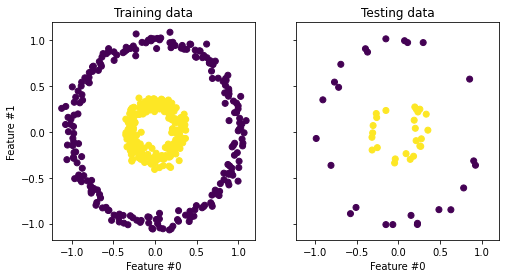

In [177]:
#plotting the dataset

import matplotlib.pyplot as plt

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [178]:
# creating object and fitting the model
model = svm_classifier(c=5.0)
model.fit(X_train, y_train)
print(model._weights)
print(model._b)

[-6.57232773  1.25908832]
0.30953476033168625


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


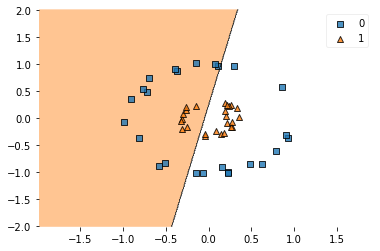

In [179]:
#printing the weight and bias
# print(f"weights={model._weights}")
# print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()

coef_=[[-0.02782514  0.00033998]]
intercept=[1.26034433e-05]


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


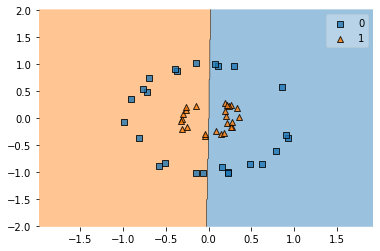

In [180]:
#linear SVC

from sklearn.svm import LinearSVC


sk_model = LinearSVC()
sk_model.fit(X_train, y_train.astype(np.int32))

print(f"coef_={sk_model.coef_}")
print(f"intercept={sk_model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), sk_model)
fig.add_subplot(ax)
plt.show()

Model test score: 1.0


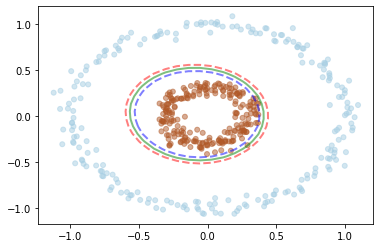

In [181]:

X, y = make_circles(n_samples=500, factor=0.3, noise=0.05, random_state=0)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

svm_poly_model = svm_classifier(kernel='poly',c=1.0)
svm_poly_model.fit(X_train, y_train)
print("Model test score:", svm_poly_model.score(X_test, y_test))
svm_poly_model.plot_boundary()


We can see the descision boundary in black for the above model and dotted red and blue lines are the margins.
To have optimal solution, we have to maximize the margin in both ways

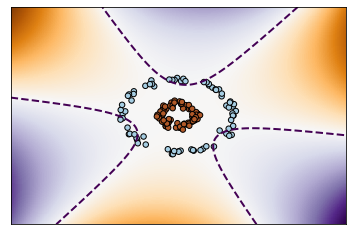

In [205]:
#poly SVC implementation
#https://github.com/ajdillhoff/CSE6363/blob/main/svm/nonlinear_svm.ipynb
from sklearn.svm import SVC

xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
X, y = make_circles(n_samples=1500, factor=0.3, noise=0.05, random_state=0)
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,stratify=y)
# X = np.random.randn(300, 2)
# Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
clf = svm.SVC( kernel='poly')
clf.fit(X_train, y_train)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(X_test[:, 0], X_test[:, 1], s=30, c=y_test, cmap=plt.cm.Paired, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()



In [183]:

#This is the class for SVM model that classifies one label class from other label classes
class OneAllsvm(svm_classifier):

  def __init__(self,uniq_label,c=1.0,kernel=np.dot, accuracy=0.001):
    super().__init__(kernel=np.dot,c=1.0)
    self.uniq_label = uniq_label
    self.c = c
    self.k = kernel
    self.acc = accuracy
  
  def binary_labels(self,label):
    temp = [1 if l == self.uniq_label else -1 for l in label]
    return temp
  
  def eval_model(self,x,labels):
    bin_labels = self.binary_labels(labels)
    # super().evaluate_model(x, bin_labels)
    pred_labels = super().predict_score(x)    ########## Need to check this part, which predict part will work for this####################
    err_count = sum(abs(pred_labels - bin_labels) / 2)
    err_ratio = err_count / len(bin_labels)
    return err_ratio

  def fit(self,x,y):
    bin_labels = self.binary_labels(y)
    super().fit(x, bin_labels)

iris = load_iris()

# this is a class for SVM classifier for multiple classifier
class MultiSVM():  
  def __init__(self,label,c=1.0,kernel=np.dot,accuracy=0.001):
    
    self.label = label
    c = [c] * len(label)
    #print(c)
    kernel = [kernel]*len(label)
    #print(kernel)
    acc = [accuracy]*len(label)
    #print(acc)
    self.classifiers = [OneAllsvm(label, c[i], kernel[i], acc[i]) for i,label in enumerate(label)]
  
  
  def fit(self,x,y):
    for classifier in self.classifiers:
      classifier.fit(x,y)

  def predict(self,x):
    pred = [ val._decision(x) for val in self.classifiers]
    max_class = np.argmax(np.array(pred), axis=0)
    return [self.classifiers[i].uniq_label for i in max_class]

  
  def eval_model(self,x,labels):
    pred_labels = self.predict(x)
    #predicted_labels = self.predict(data)
    print(pred_labels)
    for i in range(len(labels)):
          print("Test species label "+str(i)+" : ",iris.target_names[labels[i]])
          print("predicted species label "+str(i)+" : ", iris.target_names[pred_labels[i]])
          print('')
  
  

In [184]:
# IRIS dataset
from sklearn.datasets import load_iris
iris_dataset = load_iris()
iris_data = iris_dataset["data"]
#print(iris_data.shape)
iris_lables= iris_dataset["target"]

#storing features and target of iris dataset separately
x = pd.DataFrame(iris_dataset.data)  # x is in matrix format
y=pd.DataFrame(iris_dataset.target)   # y is in a vector format

# splitting the dataset to test and train
x_train,x_test,y_train,y_test = train_test_split(iris_data,iris_lables,test_size=0.1, random_state=1,stratify = y)
#print(x_train)

In [185]:
#to get the unique classes in Iris dataset
types = np.unique(iris_dataset["target"])
#print(len(types))
model_iris = MultiSVM(label = types , c=1.0)
print(x_train.shape)
print(y_train.shape)
model_iris.fit(x_train,y_train)
model_iris.eval_model(x_test, y_test)




(135, 4)
(135,)
[1, 1, 2, 0, 1, 0, 0, 2, 2, 2, 0, 1, 1, 1, 0]
Test species label 0 :  virginica
predicted species label 0 :  versicolor

Test species label 1 :  versicolor
predicted species label 1 :  versicolor

Test species label 2 :  virginica
predicted species label 2 :  virginica

Test species label 3 :  setosa
predicted species label 3 :  setosa

Test species label 4 :  versicolor
predicted species label 4 :  versicolor

Test species label 5 :  setosa
predicted species label 5 :  setosa

Test species label 6 :  setosa
predicted species label 6 :  setosa

Test species label 7 :  virginica
predicted species label 7 :  virginica

Test species label 8 :  versicolor
predicted species label 8 :  virginica

Test species label 9 :  virginica
predicted species label 9 :  virginica

Test species label 10 :  setosa
predicted species label 10 :  setosa

Test species label 11 :  versicolor
predicted species label 11 :  versicolor

Test species label 12 :  versicolor
predicted species label 12

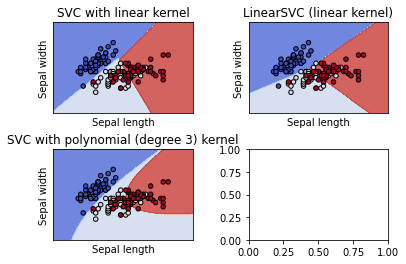

In [201]:
#Comparing the implementation with linear and polynomial kernel using sklearn.svm.SVC
from sklearn import svm
def make_meshgrid(x, y, h=0.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
def iris_inbuiltsvm_test():
  iris = load_iris()
  X = iris.data[:, :2]
  y = iris.target
  C = 1.0  # SVM regularization parameter

  models = (
      svm.SVC(kernel="linear", C=C),
      svm.LinearSVC(C=C, max_iter=10000),
      svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
  )
  models = (clf.fit(X, y) for clf in models)

  # title for the plots
  titles = (
      "SVC with linear kernel",
      "LinearSVC (linear kernel)",
      "SVC with polynomial (degree 3) kernel",
  )
  fig, sub = plt.subplots(2, 2)
  plt.subplots_adjust(wspace=0.4, hspace=0.4)
  X0, X1 = X[:, 0], X[:, 1]
  xx, yy = make_meshgrid(X0, X1)

  for clf, title, ax in zip(models, titles, sub.flatten()):
      plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
      ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      ax.set_xlabel("Sepal length")
      ax.set_ylabel("Sepal width")
      ax.set_xticks(())
      ax.set_yticks(())
      ax.set_title(title)

  plt.show()
iris_inbuiltsvm_test()